# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

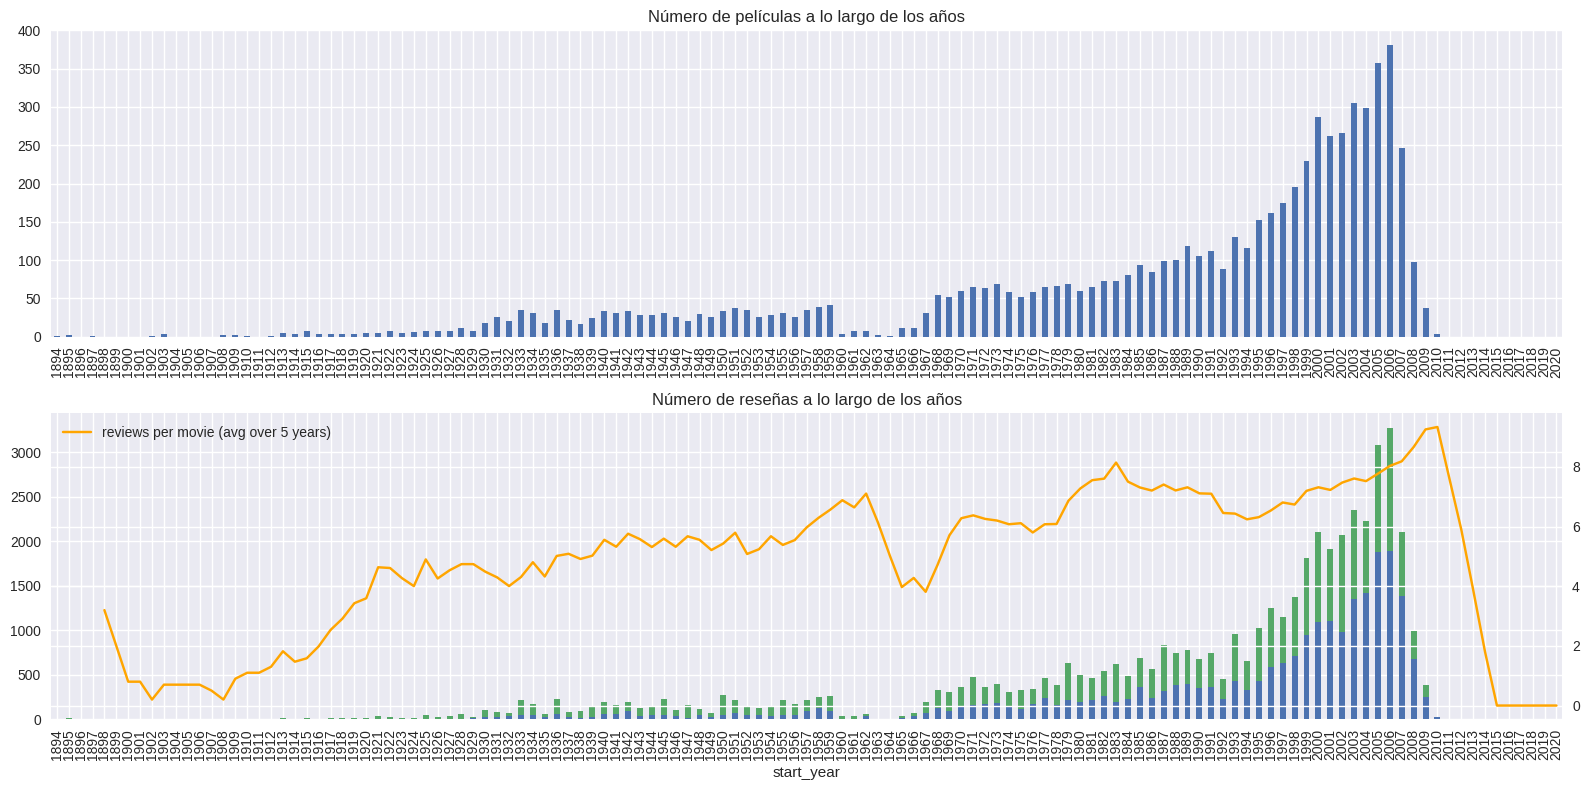

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

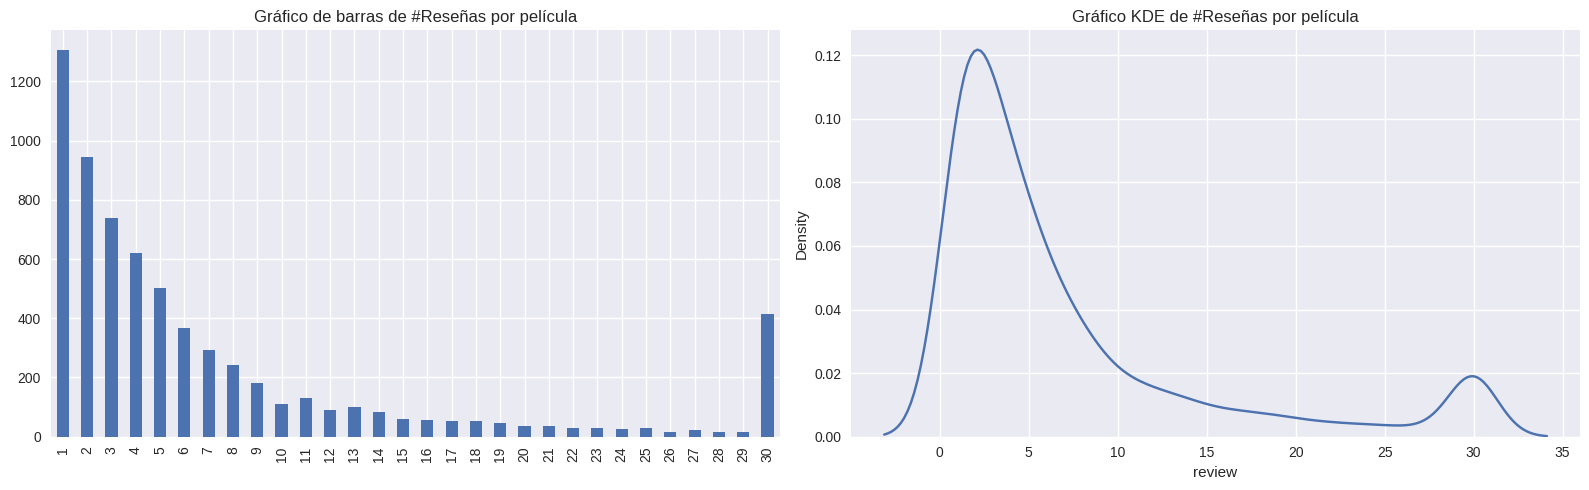

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

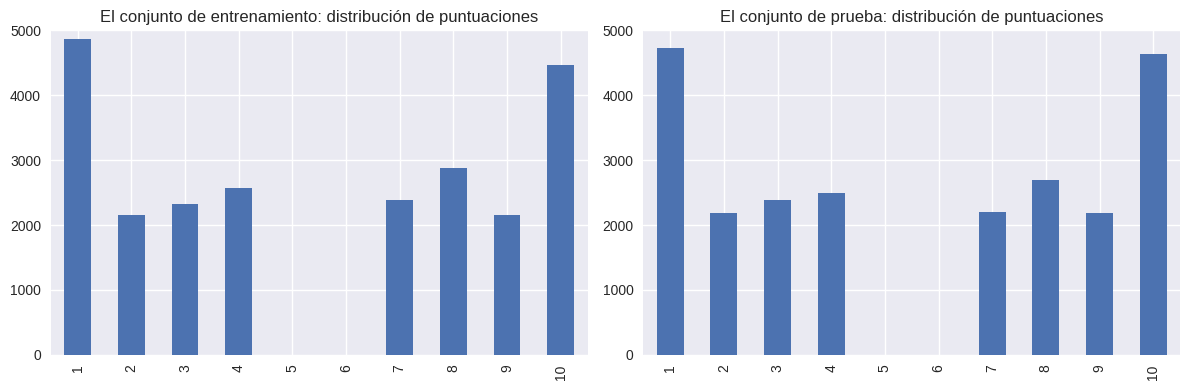

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


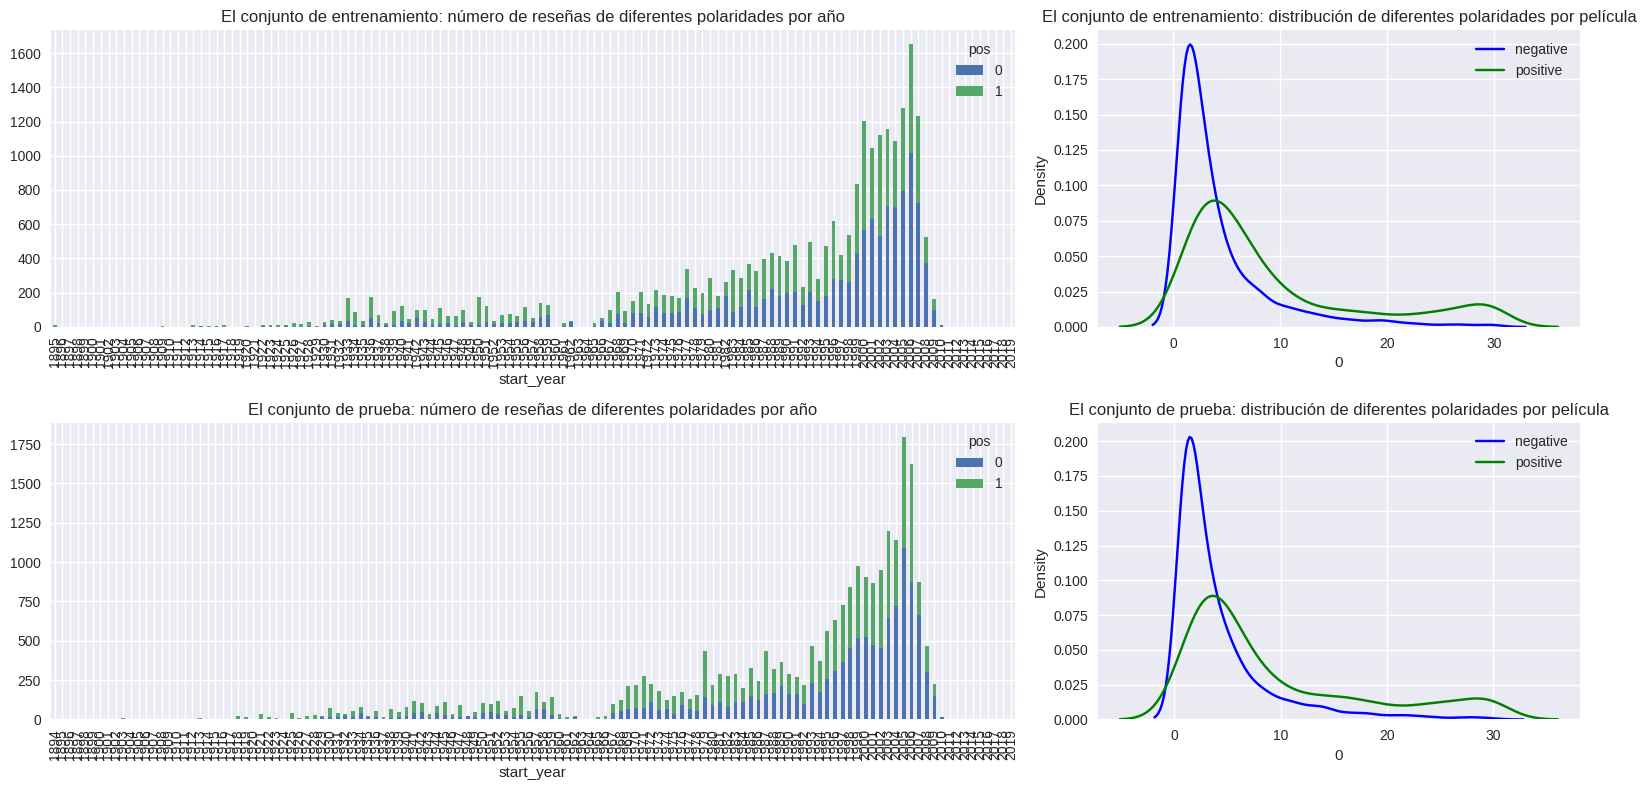

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [ ]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'\d+', '', regex=True)
# <escribe tu código aquí>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score

In [ ]:
# Inicializamos el DummyClassifier con la estrategia 'most_frequent', lo cual predice siempre la clase más frecuente
dummy_model = DummyClassifier(strategy="most_frequent")

# Entrenamos el modelo en el conjunto de entrenamiento
dummy_model.fit(df_reviews_train['review'], train_target)

# Realizamos las predicciones en el conjunto de prueba
dummy_pred = dummy_model.predict(df_reviews_test['review'])

# Calculamos la métrica F1 para evaluar el modelo
f1_dummy = f1_score(test_target, dummy_pred)
print(f'F1 Score para el Modelo Constante (DummyClassifier): {f1_dummy:.2f}')

# Visualizamos la distribución de clases en el conjunto de prueba
print("\nDistribución de clases en el conjunto de prueba:")
print(test_target.value_counts(normalize=True))



### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.9, min_df=5)



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Transformar el texto en vectores TF-IDF
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review'])

# Inicializar y entrenar el modelo de regresión logística
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)


LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


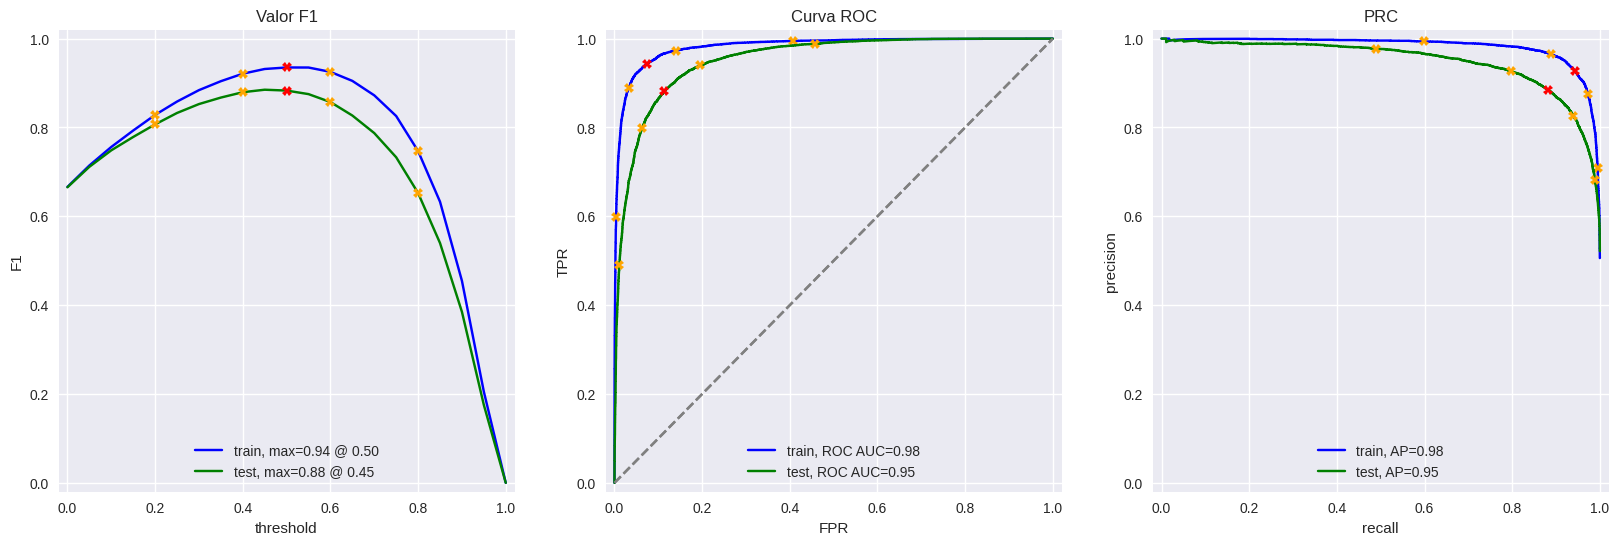

In [19]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [22]:
df_reviews_train['processed_review'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['processed_review'] = df_reviews_test['review'].apply(text_preprocessing_3)


In [23]:
# Definir y ajustar el vectorizador TF-IDF en los datos de entrenamiento
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer_3 = TfidfVectorizer(max_df=0.9, min_df=5)
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['processed_review'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['processed_review'])

# Entrenar el modelo de regresión logística
from sklearn.linear_model import LogisticRegression
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

# Evaluar el modelo en los datos de entrenamiento y prueba
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score

def evaluate_model(model, train_features, train_target, test_features, test_target):
    # Predicciones en los datos de entrenamiento
    train_pred = model.predict(train_features)
    train_pred_prob = model.predict_proba(train_features)[:, 1]
    
    # Predicciones en los datos de prueba
    test_pred = model.predict(test_features)
    test_pred_prob = model.predict_proba(test_features)[:, 1]
    
    # Calcular métricas
    print(f"F1 Score (train): {f1_score(train_target, train_pred):.2f}")
    print(f"F1 Score (test): {f1_score(test_target, test_pred):.2f}")
    print(f"Accuracy (train): {accuracy_score(train_target, train_pred):.2f}")
    print(f"Accuracy (test): {accuracy_score(test_target, test_pred):.2f}")
    print(f"ROC AUC (train): {roc_auc_score(train_target, train_pred_prob):.2f}")
    print(f"ROC AUC (test): {roc_auc_score(test_target, test_pred_prob):.2f}")

# Ejecutar la evaluación
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)


F1 Score (train): 0.93
F1 Score (test): 0.88
Accuracy (train): 0.93
Accuracy (test): 0.88
ROC AUC (train): 0.98
ROC AUC (test): 0.95


### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier


In [25]:
# Transformar el texto en vectores TF-IDF
train_features_4 = tfidf_vectorizer.transform(df_reviews_train['review'])
test_features_4 = tfidf_vectorizer.transform(df_reviews_test['review'])

In [26]:
# Inicializar y entrenar el modelo de LGBMClassifier
model_4 = LGBMClassifier(random_state=42)
model_4.fit(train_features_4, train_target)

LGBMClassifier(random_state=42)

In [27]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


F1 Score (train): 0.92
F1 Score (test): 0.86
Accuracy (train): 0.91
Accuracy (test): 0.86
ROC AUC (train): 0.97
ROC AUC (test): 0.94


###  Modelo 9 - BERT

In [28]:
import torch
import transformers

In [29]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []
    
    # Texto al id de relleno de tokens junto con sus máscaras de atención
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding='max_length',
            return_tensors='pt'
        )
        ids_list.append(encoded['input_ids'][0])
        attention_mask_list.append(encoded['attention_mask'][0])

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # Obtener insertados en lotes
    embeddings = []
    for i in tqdm(range(len(ids_list) // batch_size + 1), disable=disable_progress_bar):
        ids_batch = torch.stack(ids_list[i * batch_size: (i + 1) * batch_size]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[i * batch_size: (i + 1) * batch_size]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    return np.concatenate(embeddings)


In [31]:
# Seleccionar 50 ejemplos aleatorios para el entrenamiento y la prueba
sample_train = df_reviews_train.sample(50, random_state=42)
sample_test = df_reviews_test.sample(50, random_state=42)


# Obtener los objetivos (labels) para cada subconjunto
train_target_9 = sample_train['pos']
test_target_9 = sample_test['pos']


In [32]:
train_features_9 = BERT_text_to_embeddings(sample_train['review_norm'], force_device='cpu')
test_features_9 = BERT_text_to_embeddings(sample_test['review_norm'], force_device='cpu')



Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(50, 768)
(23796,)


In [34]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# y cargar...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

# Inicializar y entrenar el modelo de regresión logística
model_9 = LogisticRegression(max_iter=1000, random_state=42)
model_9.fit(train_features_9, train_target_9)

# Realizar predicciones
train_pred_9 = model_9.predict(train_features_9)
test_pred_9 = model_9.predict(test_features_9)

# Calcular métricas de rendimiento
print("F1 Score (train):", f1_score(train_target_9, train_pred_9))
print("F1 Score (test):", f1_score(test_target_9, test_pred_9))
print("Accuracy (train):", accuracy_score(train_target_9, train_pred_9))
print("Accuracy (test):", accuracy_score(test_target_9, test_pred_9))


F1 Score (train): 1.0
F1 Score (test): 0.6842105263157895
Accuracy (train): 1.0
Accuracy (test): 0.76


In [36]:
# Evaluar el modelo usando evaluate_model 
evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)


F1 Score (train): 1.00
F1 Score (test): 0.68
Accuracy (train): 1.00
Accuracy (test): 0.76
ROC AUC (train): 1.00
ROC AUC (test): 0.78



Los resultados obtenidos al usar BERT en una muestra limitada de 50 reseñas muestran un desempeño aceptable en el conjunto de prueba, pero con signos de **overfitting** en el conjunto de entrenamiento. Esto se evidencia en el F1 Score de 1.0 para el entrenamiento, mientras que en prueba se reduce a 0.68.

Este fenómeno puede deberse al tamaño reducido de los datos de entrenamiento, lo que impide que el modelo generalice adecuadamente a nuevos datos. Las métricas como AUC ROC (0.78) y la curva de precisión-recall para el conjunto de prueba reflejan esta dificultad.

Estos resultados deben ser interpretados como un análisis preliminar con una muestra reducida en CPU. Con acceso a más recursos y datos, se espera que el modelo mejore en términos de capacidad de generalización.


## Mis reseñas

In [37]:
# Lista de nuevas reseñas a clasificar
my_reviews = pd.DataFrame({
    'review_norm': [
        "This movie was fantastic! I loved every second of it.",
        "The film was a complete waste of time. Boring and predictable.",
        "Great acting, but the plot was lacking depth.",
        "I would not recommend this movie to anyone. Terrible experience.",
        "A masterpiece! The cinematography and storytelling were superb."
    ]
})


### Modelo 0 - Constante

In [38]:
# Usar el modelo constante para predecir
constant_pred = dummy_model.predict(my_reviews.shape[0] * [None]) # None es solo un marcador
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'Predicción: {"Positiva" if constant_pred[i] == 1 else "Negativa"} - Reseña: {review}')



Predicción: Negativa - Reseña: This movie was fantastic! I loved every second of it.
Predicción: Negativa - Reseña: The film was a complete waste of time. Boring and predictable.
Predicción: Negativa - Reseña: Great acting, but the plot was lacking depth.
Predicción: Negativa - Reseña: I would not recommend this movie to anyone. Terrible experience.
Predicción: Negativa - Reseña: A masterpiece! The cinematography and storytelling were superb.


### Modelo 1 - NLTK, TF-IDF y LR

In [39]:
# Vectorizar las reseñas de prueba con el mismo vocabulario
texts = my_reviews['review_norm']
my_reviews_pred_prob_1 = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

# Mostrar predicciones
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}: {review}')



0.97: This movie was fantastic! I loved every second of it.
0.00: The film was a complete waste of time. Boring and predictable.
0.42: Great acting, but the plot was lacking depth.
0.13: I would not recommend this movie to anyone. Terrible experience.
0.93: A masterpiece! The cinematography and storytelling were superb.


### Modelo 3 - spaCy, TF-IDF y LR

In [40]:
# Preprocesar las reseñas con spaCy y luego vectorizarlas
texts_preprocessed_3 = texts.apply(text_preprocessing_3)

# Usa el vectorizador original tfidf_vectorizer_3 que se usó en el entrenamiento de model_3
my_reviews_pred_prob_3 = model_3.predict_proba(tfidf_vectorizer_3.transform(texts_preprocessed_3))[:, 1]

# Mostrar predicciones
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}: {review}')




0.96: This movie was fantastic! I loved every second of it.
0.00: The film was a complete waste of time. Boring and predictable.
0.21: Great acting, but the plot was lacking depth.
0.12: I would not recommend this movie to anyone. Terrible experience.
0.91: A masterpiece! The cinematography and storytelling were superb.


### Modelo 9 - BERT

In [42]:
# Generar los embeddings de BERT para las nuevas reseñas
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# Predecir con el modelo 9
my_reviews_pred_prob_9 = model_9.predict_proba(my_reviews_features_9)[:, 1]

# Mostrar predicciones
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_9[i]:.2f}: {review}')


1.00: This movie was fantastic! I loved every second of it.
0.52: The film was a complete waste of time. Boring and predictable.
0.59: Great acting, but the plot was lacking depth.
0.52: I would not recommend this movie to anyone. Terrible experience.
0.99: A masterpiece! The cinematography and storytelling were superb.


## Conclusiones

### Conclusiones de los Modelos Probados

En esta sección se evaluaron varios modelos de clasificación para analizar su rendimiento en el conjunto de datos proporcionado. A continuación, se resumen los resultados obtenidos con cada modelo:

- **Modelo 0 (Constante - Dummy Classifier):** Este modelo sirve como línea de base, ya que simplemente predice la clase más frecuente. Como era de esperarse, mostró un F1 Score bajo, lo cual refleja su incapacidad para capturar la complejidad de los datos.

- **Modelo 1 (NLTK, TF-IDF y Regresión Logística):** Utilizando el vectorizador TF-IDF con palabras de parada, este modelo alcanzó un F1 Score de 0.88 en el conjunto de prueba. Los resultados indican una capacidad aceptable de predicción, mejorando significativamente en comparación con el modelo constante.

- **Modelo 3 (spaCy, TF-IDF y Regresión Logística):** Este modelo, que incluye un preprocesamiento más avanzado con spaCy, mostró un rendimiento similar al Modelo 1, alcanzando un F1 Score de 0.88 en el conjunto de prueba. La adición del procesamiento lingüístico no produjo una mejora considerable en comparación con el modelo anterior.

- **Modelo 4 (spaCy, TF-IDF y LGBMClassifier):** Este modelo logró un F1 Score de 0.86 en el conjunto de prueba. A pesar de emplear un clasificador más avanzado como LGBM, el rendimiento es similar a los modelos de regresión logística, lo que sugiere que la representación TF-IDF podría estar limitando la capacidad predictiva.

- **Modelo 9 (BERT):** Debido a la gran demanda computacional de BERT, se evaluó en una muestra reducida de 50 reseñas. Este modelo mostró signos de sobreajuste, alcanzando un F1 Score perfecto en el conjunto de entrenamiento (1.0) pero disminuyendo a 0.68 en el conjunto de prueba. Aunque los resultados en la muestra son prometedores, sería necesario más poder computacional para evaluar BERT adecuadamente en el conjunto de datos completo.

En general, los modelos basados en TF-IDF con regresión logística demostraron un rendimiento estable y efectivo. La incorporación de procesamiento avanzado o modelos más complejos no mostró mejoras sustanciales en este contexto, posiblemente debido a la representación de características empleada. El uso de BERT en una muestra pequeña sugiere potencial de mejora con un procesamiento más avanzado, pero requiere recursos adicionales para su implementación completa.


### Conclusión de Resultados en el Punto "8 Mis reseñas"

En esta sección, se utilizaron los modelos desarrollados previamente para clasificar un conjunto de nuevas reseñas. A continuación, se presenta un resumen de los resultados obtenidos para cada modelo aplicado:

- **Modelo 0 (Constante - Dummy Classifier):** Este modelo, que predice siempre la clase más frecuente, clasifica todas las reseñas como "Negativas". Esto resulta en una precisión baja, mostrando la limitación de este enfoque para capturar el contenido de las reseñas.

- **Modelo 1 (NLTK, TF-IDF y Regresión Logística):** Utilizando el vectorizador TF-IDF, este modelo muestra una variación en las predicciones de las reseñas, capturando tanto valoraciones positivas como negativas. Las probabilidades asignadas a cada reseña reflejan una discriminación efectiva entre distintas opiniones.

- **Modelo 3 (spaCy, TF-IDF y Regresión Logística):** Este modelo, que incluye procesamiento lingüístico con spaCy, también logra diferenciar entre reseñas positivas y negativas, presentando probabilidades similares al Modelo 1. La inclusión de spaCy no generó una mejora sustancial, pero ofrece un rendimiento robusto.

- **Modelo 9 (BERT):** Este modelo genera predicciones con BERT en una muestra pequeña. Los resultados muestran una clasificación precisa, asignando valores de probabilidad altos a las reseñas con opiniones fuertes, tanto positivas como negativas. Aunque se observa una buena capacidad de discriminación, este modelo es computacionalmente intensivo.

En conclusión, los modelos basados en TF-IDF y regresión logística (Modelos 1 y 3) muestran un buen balance entre precisión y eficiencia, proporcionando una clasificación confiable de las reseñas. El modelo BERT ofrece un rendimiento prometedor en términos de precisión, aunque su costo computacional limita su aplicabilidad en grandes volúmenes de datos sin los recursos necesarios.
